## Required packages

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as stats
import seaborn as sns

from sklearn import tree
from sklearn.linear_model import LogisticRegression  
from sklearn.naive_bayes import GaussianNB  
from sklearn.neighbors import KNeighborsClassifier   
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score  
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from collections import Counter
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.inspection import permutation_importance
import pickle
import shap
from sklearn.metrics import roc_curve, auc
import matplotlib.cm as cm
from sklearn.model_selection import cross_validate

## Define Functions for Machine Learning Model

In [16]:
def calc_metrics(y_test, preds):
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1score = f1_score(y_test, preds)
    return (accuracy, precision, recall, f1score)

def model_predict(model, x_train, y_train, x_test, y_test):
    model = model.fit(x_train, y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    return accuracy_score(y_predict_train, y_train), accuracy_score(y_predict_test, y_test), y_predict_test

def sort_feature(feature_names, feature_vals):
    assert len(feature_names) == len(feature_vals)
    x_and_y = [(x, y) for x, y in zip(feature_names, feature_vals)]
    x_and_y.sort(key = lambda x: -x[1])
    return [item[0] for item in x_and_y], [item[1] for item in x_and_y]

def get_feature_importance(model, x_test, y_test):
    perm_importance = permutation_importance(model, x_test, y_test)
    perm_sorted_idx = perm_importance.importances_mean.argsort()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    return (model.feature_importances_, perm_sorted_idx, shap_values)

## LightGBM Machine Learning Algorithms

In [17]:
def machine_learning(x, y, split_ratio=0.3, random_seed=28):
    xstd = x.std()
    xmean = x.mean()
    
    x = (x - x.mean()) / x.std()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = split_ratio, random_state = random_seed, shuffle = True)
    xtestvalue = x_test * xstd + xmean
    
    map = {}

    # LightGBM
    print("Starting LightGBM。。。")
    time1 = time.time()
    gbm = lgb.LGBMClassifier(random_state=random_seed)
    score_train, score_test, y_predict_test = model_predict(gbm, x_train, y_train, x_test, y_test)
    y_pred_proba = gbm.predict_proba(x_test)[:,1]
    
    dt_featureimprotance, permsortedidx, shapevalues = get_feature_importance(gbm, x_test, y_test)
    
    map['LightGBM'] = (dt_featureimprotance, permsortedidx, xstd, xmean, xtestvalue, shapevalues, x_test, y_test, y_pred_proba)

    calc_metrics(y_test, y_predict_test)

    return map

## Load Dataset 

In [18]:
result_map = {}

df = pd.read_csv('./414188yidan.csv')
df_src = df[['gender', 'age', 'siblings', 'bo', 'grade', 'sfsc', 'OBSES', 'chat',
             'care0', 'care1', 'care2','care3','care4','care5','care6','care7','care8',
             'Sregion', 'Stype', 'sssc', 'friends', 'sport', 'screen', 'game', 'video', 'book', 'ecf', 
             'BMI', 'DEP', 'PEI', 'NEI', 'SWLS', 'PMH', 'hos1', 'hos2', 'myopia', 'ST', 
             'drink', 'smoke', 'shs']].astype(float)

df_tgt = df[['traditional_any_alt']]
print("Data prepare done")

for i in range(1):
    result_map[i] = machine_learning(df_src, df_tgt.values.ravel(), random_seed=i)

Data prepare done
Starting LightGBM。。。


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


## SHAP Summary Plot

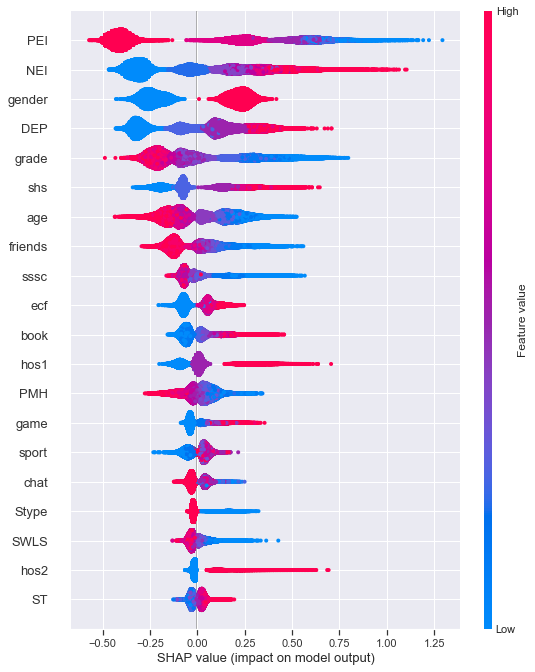

In [19]:
for model_name, vals in result_map[0].items():
    shap.summary_plot(vals[-4][1], vals[-5])

import seaborn as sns

sns.set_theme(style="darkgrid")

## K-Fold Cross-Validation

In [26]:
def cross_validation(model, _X, _y, _cv=10):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=10
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100
              }

## Grouped Bar Chart for both training and validation data

In [27]:
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold", "6st Fold", "7nd Fold", "8rd Fold", "9th Fold", "10th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=24)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=18)
        plt.ylabel(y_label, fontsize=18)
        plt.legend()
        plt.grid(True)
        plt.show()


## Model training

{'Training Accuracy scores': array([0.86529674, 0.86535039, 0.86589586, 0.86560077, 0.86526097,
       0.86535934, 0.86564548, 0.86572716, 0.86502075, 0.86581658]), 'Mean Training Accuracy': 86.54974054023576, 'Validation Accuracy scores': array([0.85828102, 0.85763721, 0.85586673, 0.85844198, 0.85554483,
       0.85787864, 0.8583615 , 0.8578672 , 0.8583501 , 0.85633803]), 'Mean Validation Accuracy': 85.74567242502174}


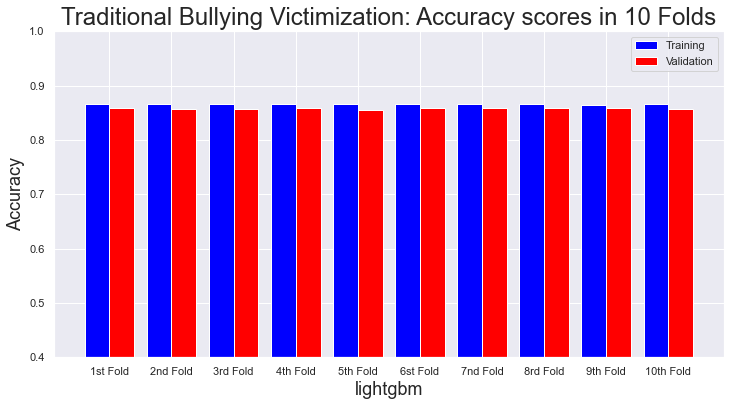

In [28]:
x_train, x_test, y_train, y_test = train_test_split(df_src, df_tgt.values.ravel(), test_size = 0.3, random_state = 28, shuffle = True)

gbm = lgb.LGBMClassifier(random_state=28)
gbm_result = cross_validation(gbm, x_test, y_test, 10)
print(gbm_result)

model_name = "lightgbm"
plot_result(model_name,
            "Accuracy",
            "Traditional Bullying Victimization: Accuracy scores in 10 Folds",
            gbm_result["Training Accuracy scores"],
            gbm_result["Validation Accuracy scores"])